
This code conducts the differential transcript analysis, as well as the transcript-expression plasticity assesement, the results of which are provided in Bitter et al. X

**Note that "bay" population in this code refers to the "coastal" population from the manuscript


In [ ]:
#Lbiraries
library(DESeq2)
library(ggplot2)
library(ggfortify)
library(plyr)
library(dplyr)
library(caret)
library(adegenet)
library(vegan)
library(RVAideMemoire)
library(Rmisc)
library(lme4)
library(EnhancedVolcano)

In [2]:
#Read in the counts matrix, which is the CGpH_Counts.csv file,
#in this file the  sequencing replicates were removed as they were mapping outliers 

cts_repsrem <- read.csv("./CGpH_Counts_RepsRem.csv", header = T, row.names=1)

#Read in transcriptome annotation provided by Moreira et al. 2015 for downstream use
annotation <- read.csv("./MoreiraTranscriptomeAnnotation.csv")
#Read in gene_id table for downstream use - this table relates the transcript id in DEG analysis to the contig/unigen from the annotation
gene_ids <- read.table("./gene_ids.tsv")
colnames(gene_ids) <- c("ID", "Gene")



Starting with differential transcript analysis via DESEQ2 (http://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)




In [5]:
#Input ColData file which has sample information (e.g. library/individual, batch (bucket), treatment, and population)
col_data <- read.csv("CGpH_ColData.csv")
col_data$Population <- revalue(col_data$Population, c(VF = "Bay", ST = "Lagoon"))
#remove coldata mapping outliers to match .cts file
col_data_subset <- col_data[-c(15, 25), ]


#Generate independent cts files for the lagoon and bay
cts_lagoon <- cts_repsrem[,c(2:6,11,13:17,22,24:28,33, 35, 36)]
coldata_lagoon <- subset(col_data_subset, Population == "Lagoon")
coldata_lagoon <- coldata_lagoon[,-c(5:9)]

#Bay pop
cts_bay <- cts_repsrem[,-c(2:6,11,13:17,22,24:28,33, 35, 36)]
coldata_bay <- subset(col_data_subset, Population == "Bay")
coldata_bay <- coldata_bay[,-c(5:9)]

#Generate cts files for both pops in ambient and both pops in low pH
cts_pops_amb <- cts_repsrem[,c(1, 11, 13:23, 33, 35:40)]
coldata_amb <- subset(col_data_subset, Treatment == "Ambient")

cts_pops_low <- cts_repsrem[,-c(1, 11, 13:23, 33, 35:40)]
coldata_low <- subset(col_data_subset, Treatment == "Low")



In [10]:
#Differentiation of populations in ambient conditions
dds_pops_amb <- DESeqDataSetFromMatrix(countData = cts_pops_amb,
                             colData = coldata_amb,
                             design = ~ Population)

dds_pops_amb
#Trim genes with low read counts 
keep <- rowSums(counts(dds_pops_amb)) >= 10
dds_pops_amb <- dds_pops_amb[keep,]
dim(dds_pops_amb)

#Add additional filter keeping genes with at least 25 reads mapped in 2 individuals
dds_pops_amb <- estimateSizeFactors(dds_pops_amb)
nc <- counts(dds_pops_amb, normalized=TRUE)
filter <- rowSums(nc >= 25) >= 2
dds_pops_amb <- dds_pops_amb[filter,]
remove(filter)
dim(dds_pops_amb)
#Set bay population as reference population
dds_pops_amb$Treatment <- relevel(dds_pops_amb$Population, ref = "Bay")
#Differential expression analysis
dds_pops_amb <- DESeq(dds_pops_amb)

resultsNames(dds_pops_amb)

#Generating results
rv_pops_amb <- rowVars(counts(dds_pops_amb, normalized = TRUE))
res_pops_amb <- results(dds_pops_amb, contrast=c("Population","Lagoon","Bay"), filter = rv_pops_amb)
summary(res_pops_amb)

#171 up, 89 down

pops_deg_amb <- as.data.frame((subset(res_pops_amb, padj < 0.1)))
pops_deg_amb <- tibble::rownames_to_column(pops_deg_amb, "Gene")
pops_deg_amb_genes <- as.data.frame(pops_deg_amb$Gene)
colnames(pops_deg_amb_genes) <- "Gene"
pops_up_amb <- as.data.frame(subset(pops_deg_amb, log2FoldChange > 0))
pops_down_amb <- as.data.frame(subset(pops_deg_amb, log2FoldChange < 0))


pops_amb_deg_annotations <- gene_ids[match(pops_deg_amb_genes$Gene, gene_ids$Gene),]
pops_amb_deg_annotations <- as.data.frame(pops_amb_deg_annotations$ID)
colnames(pops_amb_deg_annotations) <- "Gene"

#Write annotation to file
pops_amb_deg_annotation <- annotation[match(pops_amb_deg_annotations$Gene, annotation$geneID),]
write.csv(pops_amb_deg_annotation, "./DEGAnnotations/pops_amb_annotation.csv")

#Add contig/unigene id's to the data file containing LFC info
pops_deg_amb <- cbind(pops_amb_deg_annotations$Gene, pops_deg_amb)
colnames(pops_deg_amb) <- c("Contig", "Transcript", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj")

#Write files to .csv
write.csv(pops_deg_amb, "./DEGLists/pops_deg_amb.csv")

class: DESeqDataSet 
dim: 101209 20 
metadata(1): version
assays(1): counts
rownames(101209): 1 10 ... 99998 99999
rowData names(0):
colnames(20): CGpH.10 CGpH.1 ... CGpH.8 CGpH.9
colData names(4): Individual Batch Population Treatment

[1] 57074    20

[1] 12809    20

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 472 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


[1] "Intercept"                "Population_Bay_vs_Lagoon"


out of 12801 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 171, 1.3%
LFC < 0 (down)     : 89, 0.7%
outliers [1]       : 0, 0%
low counts [2]     : 3477, 27%
(mean count < 114)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [11]:
#Differentiation of populations in low pH conditions
dds_pops_low <- DESeqDataSetFromMatrix(countData = cts_pops_low,
                             colData = coldata_low,
                             design = ~ Population)

dds_pops_low
#Trim genes with low read counts 
keep <- rowSums(counts(dds_pops_low)) >= 10
dds_pops_low <- dds_pops_low[keep,]
dim(dds_pops_low)
#Add additional filter suggeste by KS
dds_pops_low <- estimateSizeFactors(dds_pops_low)
nc <- counts(dds_pops_low, normalized=TRUE)
filter <- rowSums(nc >= 25) >= 2
dds_pops_low <- dds_pops_low[filter,]
remove(filter)
dim(dds_pops_low)
#Set Bay as reference Population
dds_pops_low$Treatment <- relevel(dds_pops_low$Population, ref = "Bay")
#Differential expression analysis
dds_pops_low <- DESeq(dds_pops_low)

resultsNames(dds_pops_low)

#Generating results
rv_pops_low <- rowVars(counts(dds_pops_low, normalized = TRUE))
res_pops_low <- results(dds_pops_low, contrast=c("Population","Lagoon","Bay"), filter = rv_pops_low)
summary(res_pops_low)

#55 up 38 down

deg_low <- as.data.frame((subset(res_pops_low, padj < 0.1)))
deg_low <- add_rownames(deg_low, "Gene")
up_low <- as.data.frame(subset(deg_low, log2FoldChange > 0))
up_low <- add_rownames(up_low, "Gene")
down_low <- as.data.frame(subset(deg_low, log2FoldChange < 0))
down_low <- add_rownames(down_low, "Gene")


pops_low_deg_annotations <- gene_ids[match(deg_low$Gene, gene_ids$Gene),]
pops_low_deg_annotations <- as.data.frame(pops_low_deg_annotations$ID)
colnames(pops_low_deg_annotations) <- "Gene"

#Add contig/unigene id's to the data file containing LFC info
deg_low <- cbind(pops_low_deg_annotations$Gene, deg_low)
colnames(deg_low) <- c("Contig", "Transcript", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj")


#Write annotation to file
pops_low_deg_annotation <- annotation[match(pops_low_deg_annotations$Gene, annotation$geneID),]
write.csv(pops_low_deg_annotation, "./DEGAnnotations/pops_low_annotation.csv")
write.csv(deg_low, "./DEGLists/pops_deg_low.csv")

class: DESeqDataSet 
dim: 101209 20 
metadata(1): version
assays(1): counts
rownames(101209): 1 10 ... 99998 99999
rowData names(0):
colnames(20): CGpH.11 CGpH.12 ... CGpH.39 CGpH.40
colData names(4): Individual Batch Population Treatment

[1] 56381    20

[1] 12733    20

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 536 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


[1] "Intercept"                "Population_Bay_vs_Lagoon"


out of 12722 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 55, 0.43%
LFC < 0 (down)     : 38, 0.3%
outliers [1]       : 0, 0%
low counts [2]     : 2963, 23%
(mean count < 109)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

Saving 7 x 7 in image
Saving 7 x 7 in image


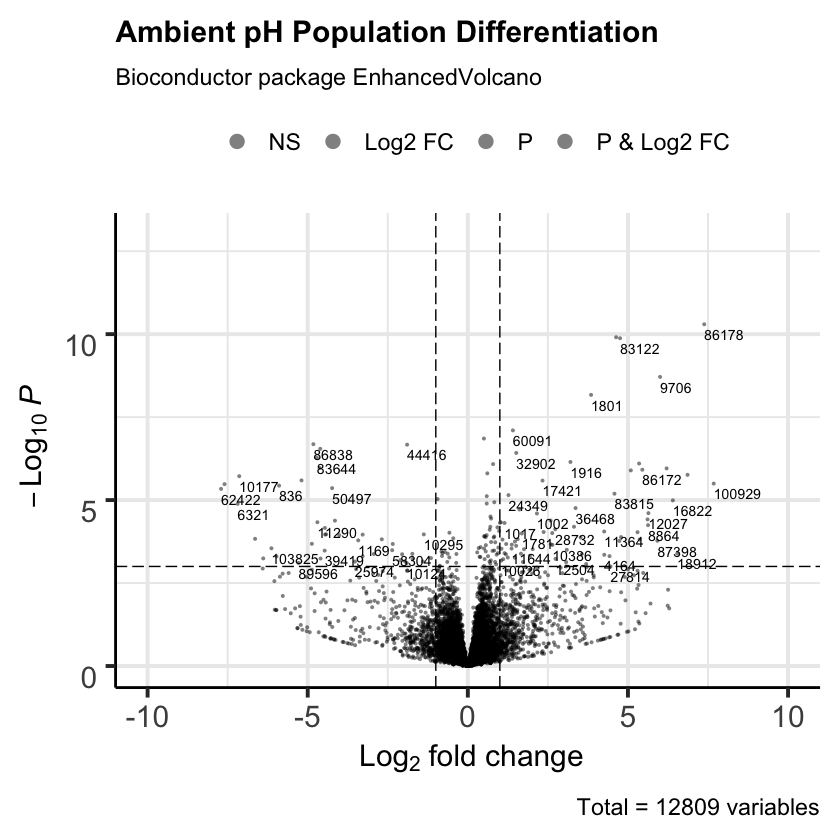

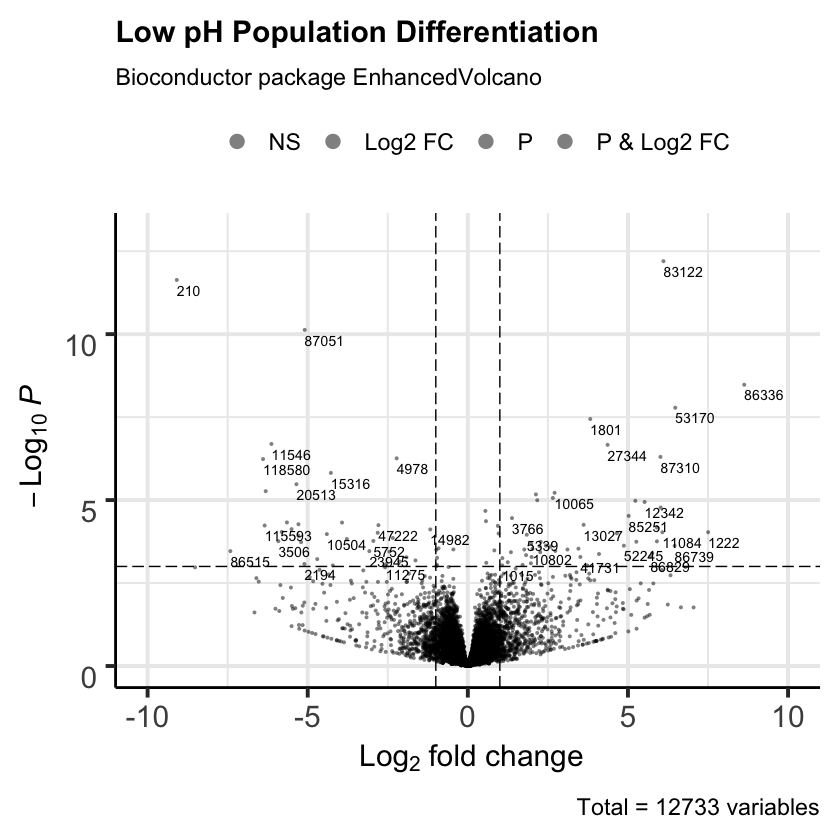

In [12]:
#Volcano plots of populations in ambient and low pH

##Ambient pH
pa <- EnhancedVolcano(res_pops_amb,
    lab = rownames(res_pops_amb),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-10, 10),
    ylim = c(0, 13),
    title = "Ambient pH Population Differentiation",
    pCutoff = 10e-4,
    shape = c(16, 16, 16, 16),
    col= c('black','black','black','black'),
    colAlpha = 0.5)

pa + ggsave("./ambient_volcano.pdf")

#Low pH
pl <- EnhancedVolcano(res_pops_low,
    lab = rownames(res_pops_low),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-10, 10),
    ylim = c(0, 13),
    title = "Low pH Population Differentiation",
    pCutoff = 10e-4,
    shape = c(16, 16, 16, 16),
    col= c('black','black','black','black'),
    colAlpha = 0.5)

pl + ggsave("./low_volcano.pdf")


In [6]:
#Treatment effect in lagoon population with low counts set to 10, and additional filter ensuring 25 reads mapped to 2 individuals to keep gene

dds_lagoon <- DESeqDataSetFromMatrix(countData = cts_lagoon,
                             colData = coldata_lagoon,
                             design = ~ Treatment)

dim(dds_lagoon)
#Trim genes with low read counts (>= 10)
keep <- rowSums(counts(dds_lagoon)) >= 10
dds_lagoon <- dds_lagoon[keep,]
dim(dds_lagoon)

#Add additional filter keeping genes with at least 25 reads mapped in 2 individuals
dds_lagoon <- estimateSizeFactors(dds_lagoon)
nc <- counts(dds_lagoon, normalized=TRUE)
filter <- rowSums(nc >= 25) >= 2
dds_lagoon <- dds_lagoon[filter,]
remove(filter)
dim(dds_lagoon)


#Set ambient as control level
dds_lagoon$Treatment <- relevel(dds_lagoon$Treatment, ref = "Ambient")
#Differential expression analysis
dds_lagoon <- DESeq(dds_lagoon)

resultsNames(dds_lagoon)

#Generating results
rv_lagoon <- rowVars(counts(dds_lagoon, normalized = TRUE))
res_lagoon <- results(dds_lagoon, contrast=c("Treatment","Low","Ambient") ,filter = rv_lagoon)
summary(res_lagoon)

#16 up and 33 down-regulated genes
#Save DEG's to dataframe
pH_deg_lagoon <- as.data.frame((subset(res_lagoon, padj < 0.1)))
pH_deg_lagoon <- tibble::rownames_to_column(pH_deg_lagoon, "Gene")
pH_deg_lagoon_genes <- as.data.frame(pH_deg_lagoon$Gene)
colnames(pH_deg_lagoon_genes) <- "Gene"
pH_up_lagoon <- as.data.frame(subset(pH_deg_lagoon, log2FoldChange > 0))
pH_down_lagoon <- as.data.frame(subset(pH_deg_lagoon, log2FoldChange < 0))

lagoon_deg_annotations <- gene_ids[match(pH_deg_lagoon_genes$Gene, gene_ids$Gene),]
lagoon_deg_annotations <- as.data.frame(lagoon_deg_annotations$ID)
colnames(lagoon_deg_annotations) <- "Gene"

#Write annotation to file
lagoon_deg_annotations <- gene_ids[match(pH_deg_lagoon_genes$Gene, gene_ids$Gene),]
lagoon_deg_annotations <- as.data.frame(lagoon_deg_annotations$ID)
colnames(lagoon_deg_annotations) <- "Gene"
lagoon_annotation <- annotation[match(lagoon_deg_annotations$Gene, annotation$geneID),]
write.csv(lagoon_annotation, "./DEGAnnotations/lagoon_annotation.csv")


#Add contig/unigene id's to the data file containing LFC info
pH_deg_lagoon <- cbind(lagoon_annotation$geneID, pH_deg_lagoon)
colnames(pH_deg_lagoon) <- c("Contig", "Transcript", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj")


#Write Lagoon DEG lists to .csv's
write.csv(pH_deg_lagoon, "./DEGLists/pH_deg_lagoon.csv")
write.csv(pH_deg_lagoon_genes, "./DEGLists/pH_deg_lagoon_genes.csv")



[1] 101209     20

[1] 56703    20

[1] 12647    20

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 510 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


[1] "Intercept"                "Treatment_Low_vs_Ambient"


out of 12635 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 16, 0.13%
LFC < 0 (down)     : 33, 0.26%
outliers [1]       : 0, 0%
low counts [2]     : 8091, 64%
(mean count < 470)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [7]:
#Treatment effect in bay population

dds_bay <- DESeqDataSetFromMatrix(countData = cts_bay,
                             colData = coldata_bay,
                             design = ~ Treatment)

dds_bay
#Trim genes with low read counts 
keep <- rowSums(counts(dds_bay)) >= 10
dds_bay <- dds_bay[keep,]
dim(dds_bay)


#Add additional filter keeping genes with at least 25 reads mapped in 2 individuals
dds_bay <- estimateSizeFactors(dds_bay)
nc <- counts(dds_bay, normalized=TRUE)
filter <- rowSums(nc >= 25) >= 2
dds_bay <- dds_bay[filter,]
remove(filter)
dim(dds_bay)
#Set ambient as control level
dds_bay$Treatment <- relevel(dds_bay$Treatment, ref = "Ambient")
#Differential expression analysis
dds_bay <- DESeq(dds_bay)

resultsNames(dds_bay)

#Generating results
rv_bay <- rowVars(counts(dds_bay, normalized = TRUE))
res_bay <- results(dds_bay, contrast=c("Treatment","Low","Ambient"), filter = rv_bay)
summary(res_bay)

# 26 up and 31 down-regulated genes

pH_deg_bay <- as.data.frame((subset(res_bay, padj < 0.1)))
pH_deg_bay <- tibble::rownames_to_column(pH_deg_bay, "Gene")
pH_deg_bay_genes <- as.data.frame(pH_deg_bay$Gene)
colnames(pH_deg_bay_genes) <- "Gene"
pH_up_bay <- as.data.frame(subset(pH_deg_bay, log2FoldChange > 0))
pH_down_bay <- as.data.frame(subset(pH_deg_bay, log2FoldChange < 0))

bay_deg_annotations <- gene_ids[match(pH_deg_bay_genes$Gene, gene_ids$Gene),]

bay_deg_annotations <- as.data.frame(bay_deg_annotations$ID)
colnames(bay_deg_annotations) <- "Gene"

#Write annotation to file
bay_annotation <- annotation[match(bay_deg_annotations$Gene, annotation$geneID),]
write.csv(bay_annotation, "./DEGAnnotations/bay_annotation.csv")

#Add contig/unigene id's to the data file containing LFC info
pH_deg_bay <- cbind(bay_annotation$geneID, pH_deg_bay)
colnames(pH_deg_bay) <- c("Contig", "Transcript", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj")


#Write Villefranche genes to .csv
write.csv(pH_deg_bay, "./DEGLists/pH_deg_bay.csv")

#create gene dataframe for downstream use
pH_deg_bay_genes <- as.data.frame(pH_deg_bay$Transcript)
colnames(pH_deg_bay_genes) <- "Gene"
write.csv(pH_deg_bay_genes, "./DEGLists/pH_deg_bay_genes.csv")

class: DESeqDataSet 
dim: 101209 20 
metadata(1): version
assays(1): counts
rownames(101209): 1 10 ... 99998 99999
rowData names(0):
colnames(20): CGpH.10 CGpH.16 ... CGpH.8 CGpH.9
colData names(4): Individual Batch Population Treatment

[1] 56639    20

[1] 12927    20

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 548 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


[1] "Intercept"                "Treatment_Low_vs_Ambient"


out of 12921 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 26, 0.2%
LFC < 0 (down)     : 30, 0.23%
outliers [1]       : 0, 0%
low counts [2]     : 5263, 41%
(mean count < 198)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image
Saving 7 x 7 in image


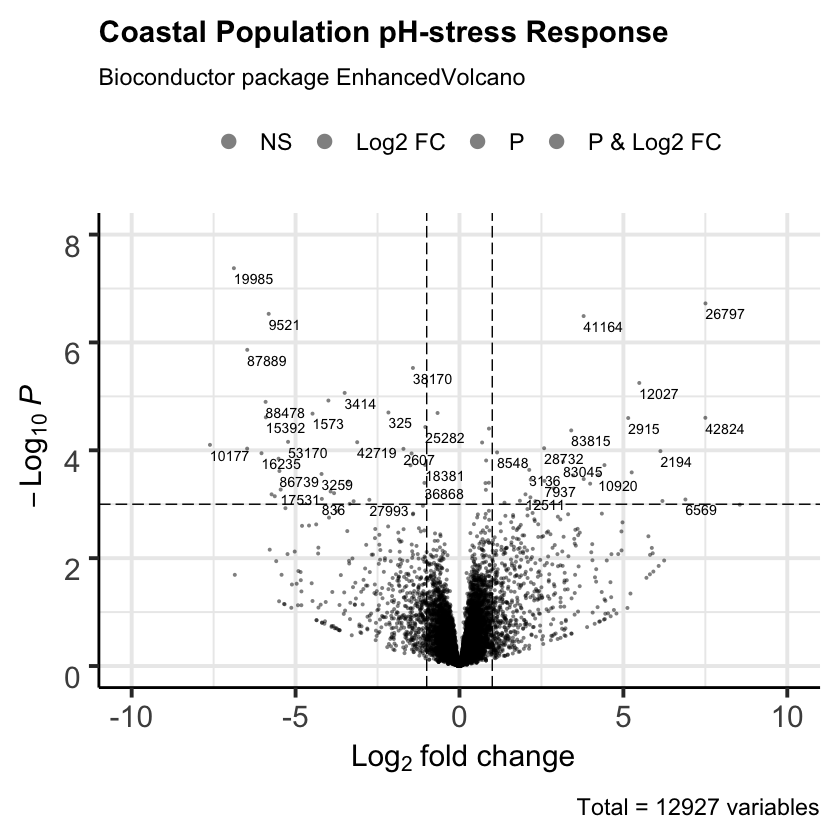

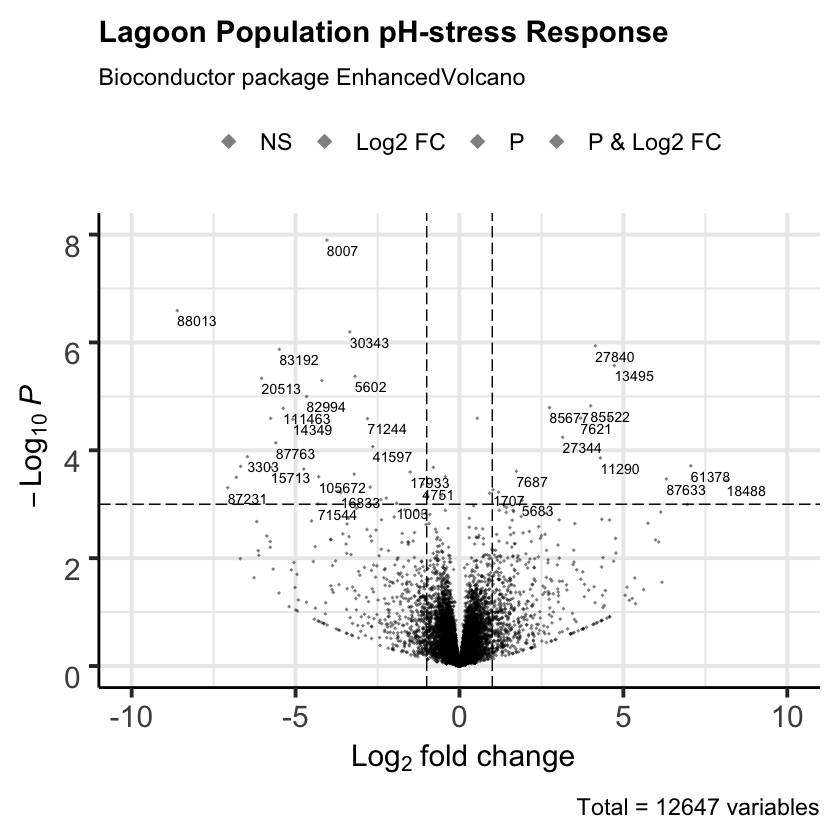

In [8]:
###Plotting treatment effect in each population using volcano plots

#Bay
pb <- EnhancedVolcano(res_bay,
    lab = rownames(res_bay),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-10, 10),
    ylim = c(0, 8),
    title = "Coastal Population pH-stress Response",
    pCutoff = 10e-4,
    shape = c(16, 16, 16, 16),
    col= c('black','black','black','black'),
    colAlpha = 0.5)

pb + ggsave("./bay_volcano.pdf")

#Lagoon
pl <- EnhancedVolcano(res_lagoon,
    lab = rownames(res_lagoon),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-10, 10),
    ylim = c(0, 8),
    title = "Lagoon Population pH-stress Response",
    pCutoff = 10e-4,
    #pointSize = 10,
    shape = c(18, 18, 18, 18),
    col= c('black','black','black','black'),
    colAlpha = 0.5)
pl + ggsave("./lagoon_volcanoe.pdf")


Now running PCA on DESeq2 outputs


In [13]:
#Rlog all data and run PCA
dds_lagoon_rlog <- rlog(dds_lagoon)
lagoon_pca_data <- plotPCA(dds_lagoon_rlog, intgroup = "Treatment", returnData=TRUE)

dds_bay_rlog <- rlog(dds_bay)
bay_pca_data <- plotPCA(dds_bay_rlog, intgroup = "Treatment", returnData=TRUE)

dds_pops_amb_rlog <- rlog(dds_pops_amb)
amb_pca_data <- plotPCA(dds_pops_amb_rlog, intgroup = "Population", returnData=TRUE)

dds_pops_low_rlog <- rlog(dds_pops_low)
low_pca_data <- plotPCA(dds_pops_low_rlog, intgroup = "Population", returnData=TRUE)

Warning message:
“Removed 1 rows containing missing values (geom_point).”

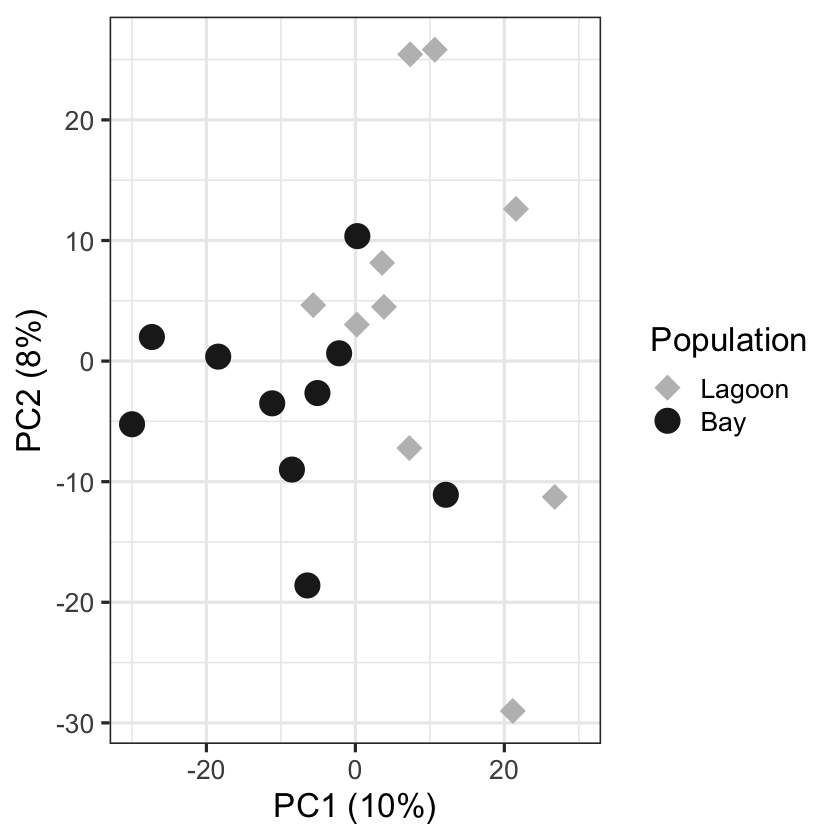

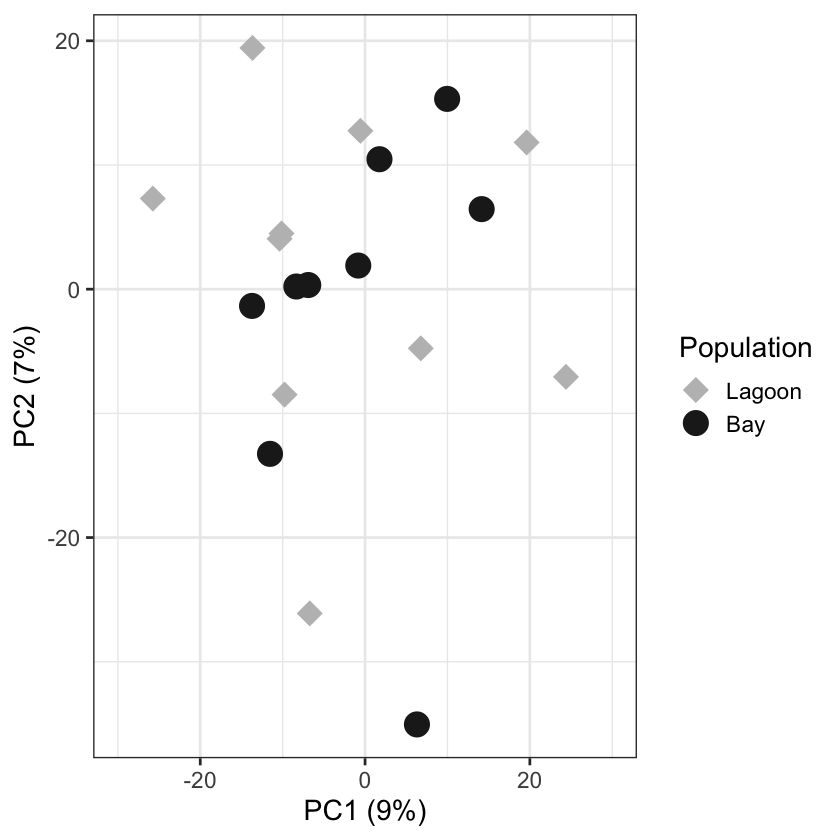

In [17]:
#Plotting pca of population differentiation in ambient and low pH

ambient_pca <- ggplot(amb_pca_data, aes(x = PC1, y = PC2, shape= Population, colour = Population)) +
    geom_point(size = 7) +
    scale_shape_manual(values = c(18, 16)) +
    scale_colour_manual(values = c("grey", "grey12")) +
    scale_fill_manual(values = c("grey", "grey12")) +
    xlab( "PC1 (10%)") +
    ylab("PC2 (8%)")+
    xlim(-30,30) +
    theme_bw(base_size = 20)

#Populations in Low pH conditions bw

low_pca <- ggplot(low_pca_data, aes(x = PC1, y = PC2, shape = Population, colour = Population)) +
    geom_point(size = 7) +
    scale_shape_manual(values = c(18, 16)) +
    scale_colour_manual(values = c("grey", "grey12")) +
    scale_fill_manual(values = c("grey", "grey12")) +
    xlab( "PC1 (9%)") +
    ylab("PC2 (7%)") +
    xlim(-30, 30) +
    theme_bw(base_size = 17)
ambient_pca
low_pca

In [14]:
#Now running stats to identify a PC-based signature of popualtion differentiation in each treatment
# Anova to quantify difference in populations in ambient using PC1
summary(aov(PC1 ~ Population, data = amb_pca_data))
##p = 0.002

perm.anova(PC1 ~ Population, data = amb_pca_data, nperm = 999)
##p = 0.001

##Anova + perm.anova to quantify difference in populations in low pH using PC1
summary(aov(PC1 ~ Population, data = low_pca_data))
##p = 0.448

perm.anova(PC1 ~ Population, data = low_pca_data, nperm = 999)
##p = 0.458



            Df Sum Sq Mean Sq F value  Pr(>F)   
Population   1   1870  1870.5    13.8 0.00158 **
Residuals   18   2439   135.5                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  |======================================================================| 100%


,Sum Sq,Df,Mean Sq,F value,Pr(>F)
,<dbl>,<int>,<dbl>,<chr>,<chr>
Population,1870.496,1,1870.4963,13.8024806928594,0.00300
Residuals,2439.339,18,135.5189,,NA


            Df Sum Sq Mean Sq F value Pr(>F)
Population   1    138   137.7   0.601  0.448
Residuals   18   4123   229.0               

  |======================================================================| 100%


,Sum Sq,Df,Mean Sq,F value,Pr(>F)
,<dbl>,<int>,<dbl>,<chr>,<chr>
Population,137.6591,1,137.6591,0.601043794229581,0.43600
Residuals,4122.6021,18,229.0334,,NA



Generating inputs for goMWU analysis and plasticity analysis (below)



In [35]:
#Lagoon pH effect
lagoon_logchange <- as.data.frame(res_lagoon)
lagoon_logchange <- tibble::rownames_to_column(lagoon_logchange, "ID")
lagoon_logchange <- lagoon_logchange[,c(1,3)]
write.table(lagoon_logchange, file = "./lagoon_logchange.csv", sep = ",", row.names = FALSE)

lagoon_logpval <- as.data.frame(res_lagoon)
lagoon_logpval <- tibble::rownames_to_column(lagoon_logpval, "ID")
lagoon_logpval$logpval <- -log(lagoon_logpval$pvalue)
lagoon_logpval <- lagoon_logpval[,c(1,8)]
write.table(lagoon_logpval, file = "./lagoon_logpval.csv", sep = ",", row.names = FALSE)

#File with transcript id, contig/unigene id, lfc, pvalue, padj
lagoon_supp <- as.data.frame(res_lagoon)
lagoon_supp <- tibble::rownames_to_column(lagoon_supp, "ID")
lagoon_supp <- lagoon_supp[,c(1,3,6,7)]
#Add contig/unigene info
l_ids <- gene_ids[match(lagoon_supp$ID, gene_ids$Gene),]
l_ids <- na.omit(l_ids)
lagoon_supp <- cbind(l_ids, lagoon_supp)
lagoon_supp <- lagoon_supp[,-2]
colnames(lagoon_supp) <- c("Reference_Contig", "Transcript_ID", "log2FoldChange", "pvalue", "padj")
#head(lagoon_supp)
write.table(lagoon_supp, file = "./lagoon_supp.csv", sep = ",", row.names = FALSE)

In [34]:
#Bay and pH effect

bay_logchange <- as.data.frame(res_bay)
bay_logchange <- tibble::rownames_to_column(bay_logchange, "ID")
bay_logchange <- bay_logchange[,c(1,3)]
write.table(bay_logchange, file = "./bay_logchange.csv", sep = ",", row.names = FALSE)

bay_logpval <- as.data.frame(res_bay)
bay_logpval <- tibble::rownames_to_column(bay_logpval, "ID")
bay_logpval$logpval <- -log(bay_logpval$pvalue)
bay_logpval <- bay_logpval[,c(1,8)]
write.table(bay_logpval, file = "./bay_logpval.csv", sep = ",", row.names = FALSE)

#File with transcript id, contig/unigene id, lfc, pvalue, padj
bay_supp <- as.data.frame(res_bay)
bay_supp <- tibble::rownames_to_column(bay_supp, "ID")
bay_supp <- bay_supp[,c(1,3,6,7)]
#Add contig/unigene info
b_ids <- gene_ids[match(bay_supp$ID, gene_ids$Gene),]
b_ids <- na.omit(b_ids)
bay_supp <- cbind(b_ids, bay_supp)
bay_supp <- bay_supp[,-2]
colnames(bay_supp) <- c("Reference_Contig", "Transcript_ID", "log2FoldChange", "pvalue", "padj")
write.table(bay_supp, file = ".coastal_supp.csv", sep = ",", row.names = FALSE)

In [33]:
#Pops in ambient pH
amb_logchange <- as.data.frame(res_pops_amb)
amb_logchange <- tibble::rownames_to_column(amb_logchange, "ID")
amb_logchange <- amb_logchange[,c(1,3)]
write.table(amb_logchange, file = "./amb_logchange.csv", sep = ",", row.names = FALSE)

amb_logpval <- as.data.frame(res_pops_amb)
amb_logpval <- tibble::rownames_to_column(amb_logpval, "ID")
amb_logpval$logpval <- -log(amb_logpval$pvalue)
amb_logpval <- amb_logpval[,c(1,8)]
write.table(amb_logpval, file = "./amb_logpval.csv", sep = ",", row.names = FALSE)

#File with transcript id, contig/unigene id, lfc, pvalue, padj
amb_supp <- as.data.frame(res_pops_amb)
amb_supp <- tibble::rownames_to_column(amb_supp, "ID")
amb_supp <- amb_supp[,c(1,3,6,7)]
#Add contig/unigene info
amb_ids <- gene_ids[match(amb_supp$ID, gene_ids$Gene),]
amb_ids <- na.omit(amb_ids)
amb_supp <- cbind(amb_ids, amb_supp)
amb_supp <- amb_supp[,-2]
colnames(amb_supp) <- c("Reference_Contig", "Transcript_ID", "log2FoldChange", "pvalue", "padj")
write.table(bay_supp, file = "./benign_supp.csv", sep = ",", row.names = FALSE)

In [32]:
#Pops in low pH
low_logchange <- as.data.frame(res_pops_low)
low_logchange <- tibble::rownames_to_column(low_logchange, "ID")
low_logchange <- low_logchange[,c(1,3)]
write.table(low_logchange, file = "./low_logchange.csv", sep = ",", row.names = FALSE)

low_logpval <- as.data.frame(res_pops_low)
low_logpval <- tibble::rownames_to_column(low_logpval, "ID")
low_logpval$logpval <- -log(low_logpval$pvalue)
low_logpval <- low_logpval[,c(1,8)]
write.table(low_logpval, file = "./low_logpval.csv", sep = ",", row.names = FALSE)

#File with transcript id, contig/unigene id, lfc, pvalue, padj
low_supp <- as.data.frame(res_pops_low)
low_supp <- tibble::rownames_to_column(low_supp, "ID")
low_supp <- low_supp[,c(1,3,6,7)]
#Add contig/unigene info
low_ids <- gene_ids[match(low_supp$ID, gene_ids$Gene),]
low_ids <- na.omit(low_ids)
low_supp <- cbind(low_ids, low_supp)
low_supp <- low_supp[,-2]
colnames(low_supp) <- c("Reference_Contig", "Transcript_ID", "log2FoldChange", "pvalue", "padj")
write.table(bay_supp, file = "./stressful_supp.csv", sep = ",", row.names = FALSE)


Now broadly examining differences in pH-stress plasticity between treatments




In [25]:
#Use log-fold change dataframe generated for goMWU
##read in dataframes
l.lc <- read.csv("./lagoon_lc.csv") #lagoon population log change data
b.lc <- read.csv("./bay_lc.csv") #bay (coastal) population log change data
amb.lc <- read.csv("./amb_lc.csv") #ambient treatment population comparisson log change data
low.lc <- read.csv("./low_lc.csv") #low pH treatment population comparisson log change data

In [26]:
#First comparing each populations low pH response

##Generating columns with absolute-change data (ignore direction of change) 
l.lc$abs_change <- abs(l.lc$log2FoldChange)
b.lc$abs_change <- abs(b.lc$log2FoldChange)


##Look at aggregate of total change in overlapping genes
b.lc_shared <- b.lc[match(l.lc$ID,b.lc$ID), ]
b.lc_shared <- na.omit(b.lc_shared)
l.lc_shared <- l.lc[match(b.lc$ID, l.lc$ID),]
l.lc_shared <- na.omit(l.lc_shared)


##Subset by up and down regulated genes
l.lc_up <- subset(l.lc, log2FoldChange > 0)
l.lc_down <- subset(l.lc, log2FoldChange < 0)
b.lc_up <- subset(b.lc, log2FoldChange > 0)
b.lc_down <- subset(b.lc, log2FoldChange < 0)


#Continue with up/down subset and only look at overlapping genes
b.lc_up_shared <- b.lc_up[match(l.lc_up$ID,b.lc_up$ID), ]
b.lc_up_shared <- na.omit(b.lc_up_shared)
l.lc_up_shared <- l.lc_up[match(b.lc_up$ID, l.lc_up$ID),]
l.lc_up_shared <- na.omit(l.lc_up_shared)

b.lc_down_shared <- b.lc_down[match(l.lc_down$ID,b.lc_down$ID), ]
b.lc_down_shared <- na.omit(b.lc_down_shared)
l.lc_down_shared <- l.lc_down[match(b.lc_down$ID, l.lc_down$ID),]
l.lc_down_shared <- na.omit(l.lc_down_shared)

l.lc_shared$Population = "Lagoon"
b.lc_shared$Population = "Coastal"
abs <- rbind(l.lc_shared, b.lc_shared)
l.lc_up_shared$Population = "Lagoon"
b.lc_up_shared$Population = "Coastal"
l.lc_down_shared$Population = "Lagoon"
b.lc_down_shared$Population = "Coastal"
up <- rbind(l.lc_up_shared, b.lc_up_shared)
down <- rbind(l.lc_down_shared, b.lc_down_shared)


##Summary stats
abs_summstats <- summarySE(data = abs, measurevar = "abs_change", groupvars = c("Population"))
up_summstats <- summarySE(data = up, measurevar = "abs_change", groupvars = c("Population"))
down_summstats <- summarySE(data = down, measurevar = "abs_change", groupvars = c("Population"))

##Now run stats on differences in plastic response
##First, check normality of data
shapiro.test(l.lc_up_shared$abs_change)$p.val
shapiro.test(b.lc_up_shared$abs_change)$p.val
shapiro.test(l.lc_down_shared$abs_change)$p.val
shapiro.test(b.lc_down_shared$abs_change)$p.val
###Data definitely  not normal, so analyze using perm.anova

perm.anova(abs_change ~ Population, data = abs, nperm = 999) #p = 0.001
perm.anova(log2FoldChange ~ Population, data = up, nperm = 999) #p = 0.16
perm.anova(log2FoldChange ~ Population, data = down, nperm = 999) #p = 0.043

[1] 3.041377e-66

[1] 7.906582e-67

[1] 2.789638e-65

[1] 2.125692e-62

  |======================================================================| 100%


,Sum Sq,Df,Mean Sq,F value,Pr(>F)
,<dbl>,<int>,<dbl>,<chr>,<chr>
Population,7.550228,1,7.5502277,25.3659110249042,0.00100
Residuals,6760.879695,22714,0.2976525,,NA


  |======================================================================| 100%


,Sum Sq,Df,Mean Sq,F value,Pr(>F)
,<dbl>,<int>,<dbl>,<chr>,<chr>
Population,0.5070728,1,0.5070728,2.05203594004201,0.17900
Residuals,1449.5305405,5866,0.2471071,,NA


  |======================================================================| 100%


,Sum Sq,Df,Mean Sq,F value,Pr(>F)
,<dbl>,<int>,<dbl>,<chr>,<chr>
Population,1.144658,1,1.1446576,4.12216113301851,0.04300
Residuals,1403.969625,5056,0.2776839,,NA


In [ ]:
#Testing whether densities of log-fold-change for each popoualtion are different using KS test

#Ignoring direction of change (absolute value)
ks.test(l.lc_shared$abs_change, b.lc_shared$abs_change)  #D = 0.059, p < 0.001



#Re-run on LFC
ks.test(l.lc_shared$log2FoldChange, b.lc_shared$log2FoldChange)  #D = 0.059, p < 0.001



#Significant diferrence in densities

Saving 7 x 7 in image


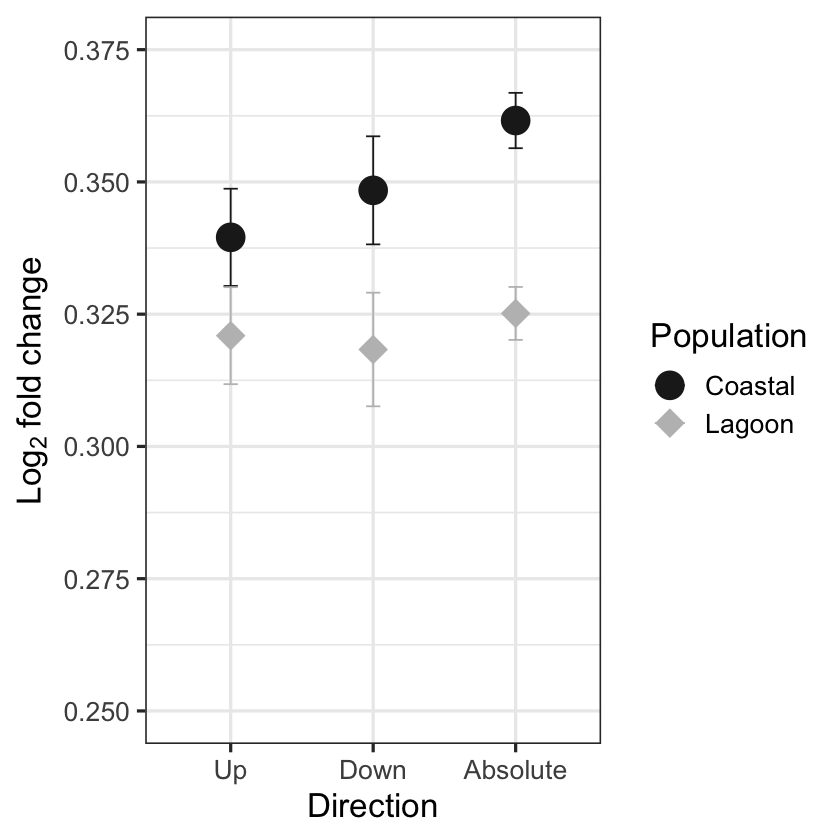

In [29]:
#Visualizing transcriptome-wide changes in each population using log-fold-change data

##plot magnitude of change for up, down, and absolute change
p <- ggplot(df1, aes(x = Change, y = abs_change, shape = Population, colour = Population)) +
    geom_errorbar(aes(ymin=abs_change-se, ymax = abs_change+se), width=.1) +
    geom_point(size = 8) +
    labs(y=Log[2]~fold~change) +
    xlab("Direction") +
    ylim(0.25,0.375) +
    scale_shape_manual("Population", values = c("Lagoon" = 18, "Coastal" = 16)) +
    scale_colour_manual(values = c("grey12", "grey")) +
    scale_fill_manual(values = c("grey12", "grey")) +
    scale_x_discrete(limits=c("Up", "Down", "Absolute")) +
    theme_bw(base_size = 20)
p + ggsave("../../CGpH_Figures/up_down_total_bw.pdf")


Saving 7 x 7 in image
Warning message:
“Removed 99 rows containing non-finite values (stat_density).”Warning message:
“Removed 99 rows containing non-finite values (stat_density).”

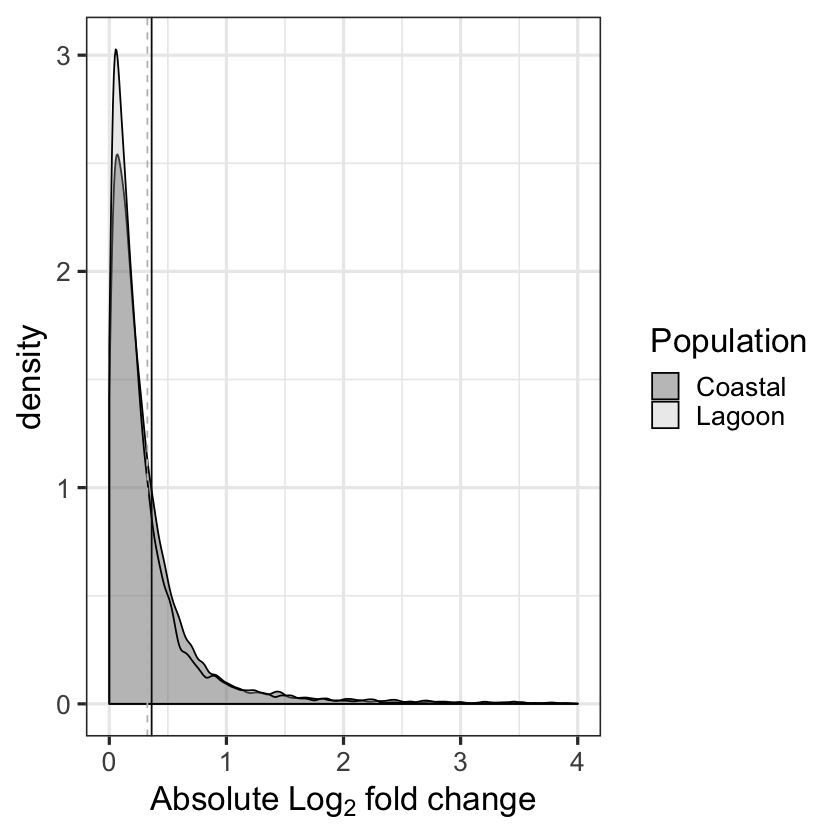

In [30]:
#Plotting overlaying densities ofthe distribution of log-fold-changes
df <- rbind(l.lc_shared, b.lc_shared)

p <- ggplot(df, aes(x = abs_change)) +
        geom_density(aes(group = Population, fill = Population), alpha = 0.3) +
        xlim(0, 4) + 
        labs(x=Absolute~Log[2]~fold~change) +
        geom_vline(xintercept = mean(l.lc_shared$abs_change), colour = "grey", linetype = "dashed") +
        geom_vline(xintercept = mean(b.lc_shared$abs_change), colour = "grey3") +
        scale_fill_manual("Population", values = c("Lagoon" = "grey", "Coastal" = "grey3")) +
        theme_bw(base_size = 20)

p + ggsave("../../CGpH_Figures/logchange_density_bw.pdf")

What is the expression of low pH response genes in bay, in the lagoon population in ambient pH 
    -e.g. are they just already at higher/lower expression?
Method: grab list of sig up/down regulated genes in bay. Then, look at what the log-fold change difference is between the pops in those genes in ambient conditiosn ((1)is the direction the same (2) is magnitude of expression greater in lagoon.)


In [40]:
#Read in necessary dataframes (all generated above)
##bay differentially expressed transcripts
bay_degs <- read.csv("./pH_deg_bay.csv")
bay_degs$abs_change <- abs(bay_degs$log2FoldChange)
bay_up <- subset(bay_degs, log2FoldChange > 0)
bay_down <- subset(bay_degs, log2FoldChange < 0)
##lagoon differentially expressed transcripts
lagoon_degs <- read.csv("./pH_deg_lagoon.csv")
lagoon_degs$abs_change <- abs(lagoon_degs$log2FoldChange)
lagoon_up <- subset(lagoon_degs, log2FoldChange > 0)
lagoon_down <- subset(lagoon_degs, log2FoldChange < 0)
#pH-responsive genes
pH_degs <- rbind(bay_degs, lagoon_degs)
pH_degs$abs_change <- abs(pH_degs$log2FoldChange)
pH_up <- subset(pH_degs, log2FoldChange > 0)
pH_down <- subset(pH_degs, log2FoldChange < 0)
pH_all <- rbind(pH_up, pH_down)
pH_all$Category <- "pH Transcripts"
##genes differentiating populations in ambient conditions
amb_degs <- read.csv("./pops_deg_amb.csv")
amb_degs$Category <- "All_Transcripts"
amb_degs$abs_change <- abs(amb_degs$log2FoldChange)
amb_degs_up <- subset(amb_degs, log2FoldChange > 0)
amb_degs_down <- subset(amb_degs, log2FoldChange < 0)
amb.lc$Category <- "All_Transcripts"
amb.lc$abs_change <- abs(amb.lc$log2FoldChange)
amb.lc.up <- subset(amb.lc, log2FoldChange > 0)
amb.lc.down <- subset(amb.lc, log2FoldChange > 0)


low_degs <- read.csv("./pops_deg_low.csv")
low_degs$Category <- "All_Transcripts"
low_degs$abs_change <- abs(low_degs$log2FoldChange)
low_degs_up <- subset(low_degs, log2FoldChange > 0)
low_degs_down <- subset(low_degs, log2FoldChange < 0)



In [41]:
#Grab the expression difference between populations of the pH genes in ambient conditions
amb_pH_degs <- amb_degs[match(pH_all$Contig, amb_degs$Contig),]

amb_pH_degs <- na.omit(amb_pH_degs)
dim(amb_pH_degs)
mean(amb_pH_degs$abs_change)
amb_pH_degs$Category <- "pH Genes"
##Remove frontloaded genes from amb_deg dataframe, and then re-add them with the correct Category label
dim(amb_degs)
amb_degs <- subset(amb_degs, !(Contig %in% amb_pH_degs$Contig))
dim(amb_degs)
amb_degs <- rbind(amb_pH_degs, amb_degs)
dim(amb_degs)
perm.anova(abs_change ~ Category, data = amb_degs, nperm = 999) #F(1,258) = 13.62, p = 0.001


[1] 29 11

[1] 3.599137

[1] 260  11

[1] 231  11

[1] 260  11

  |======================================================================| 100%


,Sum Sq,Df,Mean Sq,F value,Pr(>F)
,<dbl>,<int>,<dbl>,<chr>,<chr>
Category,50.99398,1,50.993982,13.6188471484891,0.00100
Residuals,966.04707,258,3.744368,,NA


Saving 7 x 7 in image


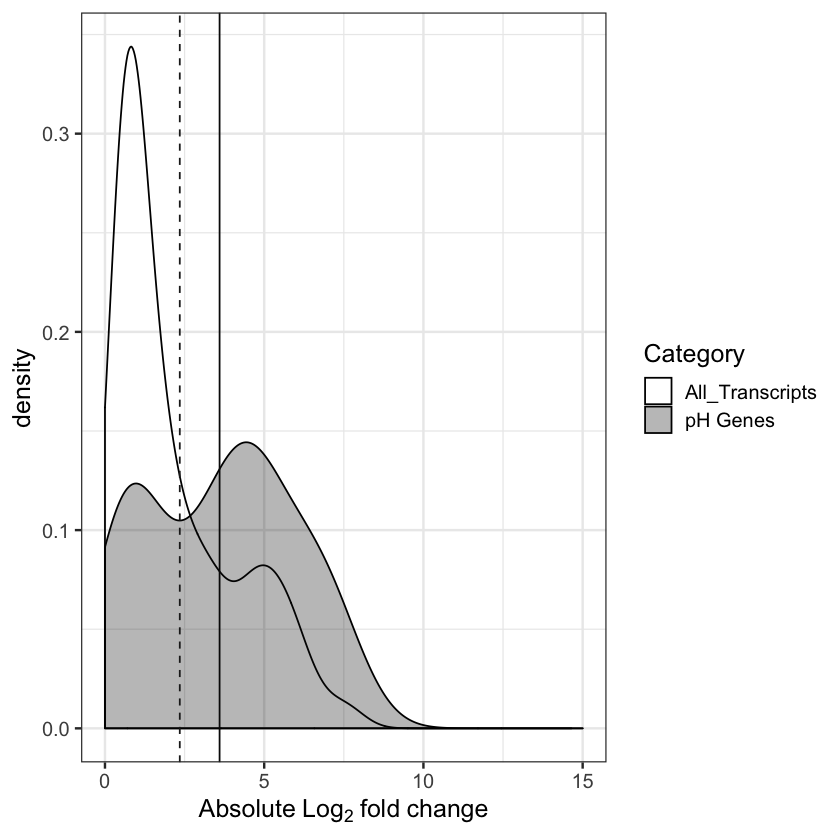

In [39]:
#plot overlaying densities as bw
p <- ggplot(amb_degs, aes(x = abs_change, group = Category, fill = Category)) +
        geom_density(aes(group = Category, fill = Category), alpha = 0.3) +
        xlim(0, 15) +
        geom_vline(xintercept = mean(amb_pH_degs$abs_change), colour = "grey3") +
        geom_vline(xintercept = mean(amb_degs$abs_change), colour = "grey12", linetype = "dashed") +
        labs(x=Absolute~Log[2]~fold~change) +
        scale_fill_manual("Category", values = c("pH Genes" = "grey3", "Population Genes" = "grey")) +
        theme_bw(base_size = 15)


p + ggsave("./frontload_bw.pdf")
